In [1]:
import sys
sys.path.append('../')

import tquant as tq


import tensorflow as tf
from datastore import *
import matplotlib.pyplot as plt
import QuantLib as ql

def get_ql_curve(curve_tq, evaluation_date):
    evaluation_date_ql = ql.Date.from_date(evaluation_date)
    dates_ql = [evaluation_date_ql + d for d in curve_tq._pillar_days]
    rates_ql = [r.numpy() for r in curve_tq._rates]
    curve_ql = ql.ZeroCurve(dates_ql, rates_ql, ql.ActualActual(ql.ActualActual.ISDA), ql.TARGET())
    curve_ql.enableExtrapolation()
    return curve_ql


# Settings

In [2]:
tq.Settings.evaluation_date = date(2024, 4, 30)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

rates = ir_eur_curve_estr['quote'].values
times = ir_eur_curve_estr['daycount'].values/365


rate_curve = tq.RateCurve(evaluation_date, times, rates, 'LINEAR', tq.DayCounterConvention.ActualActual)
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR)

# Hull and White

In [3]:
a = 0.03
sigma = 0.02

hw_tq = tq.HullWhiteProcess(rate_curve, a, sigma)

schedule_gen = tq.ScheduleGenerator(calendar, tq.BusinessDayConvention.Unadjusted)
end_date = calendar.advance(evaluation_date, 30, tq.TimeUnit.Years, tq.BusinessDayConvention.ModifiedFollowing)
dates = schedule_gen.generate(evaluation_date, end_date, 6, tq.TimeUnit.Months)
date_grid = tq.DateGrid(dates, tq.DayCounterConvention.ActualActual)

kernel = tq.GaussianShortRateGenerator(hw_tq, date_grid)

short_rate = kernel.simulate(n_paths=1000)
short_rate_df = pd.DataFrame(short_rate).T

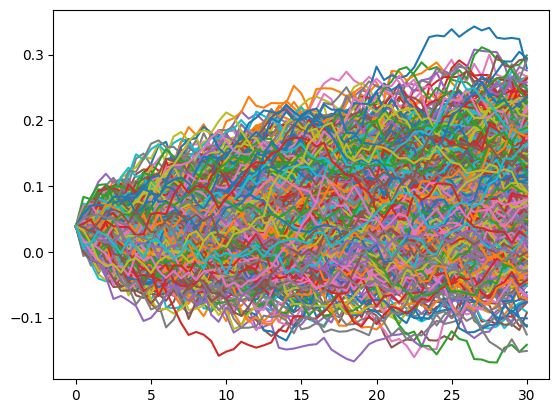

In [4]:
plt.plot(date_grid.times, short_rate_df)
plt.show()

In [5]:
simulated_curves = kernel.simulate_curves(1000)

In [ ]:
# class ShortRate(ABC, StochasticProcess):
#     def __init__(self):
#         super().__init__()

In [ ]:
# creazione curve future zcb 
# pricing swap a date future

## QL

In [ ]:
# QL
rate_curve_ql = get_ql_curve(rate_curve, evaluation_date)
hrate_curve_ql = ql.YieldTermStructureHandle(rate_curve_ql)
hw_ql = ql.HullWhiteProcess(hrate_curve_ql, a, sigma)

timestep_len= len(time_grid[1:])
dimension = hw_ql.factors()
Npaths = 1000
gen_paths = np.zeros((dimension, timestep_len+1, Npaths))

rng = ql.UniformRandomSequenceGenerator(dimension * timestep_len, ql.UniformRandomGenerator())
sequenceGenerator = ql.GaussianRandomSequenceGenerator(rng)
pathGenerator = ql.GaussianMultiPathGenerator(hw_ql, list(time_grid), sequenceGenerator, False)

for i in range(Npaths):
    samplePath = pathGenerator.next()
    values = samplePath.value() 

    for j in range(dimension):
        gen_paths[j, :, i] = values[0]

In [ ]:
short_rate_df_ql =  pd.DataFrame(gen_paths[0,:,:])

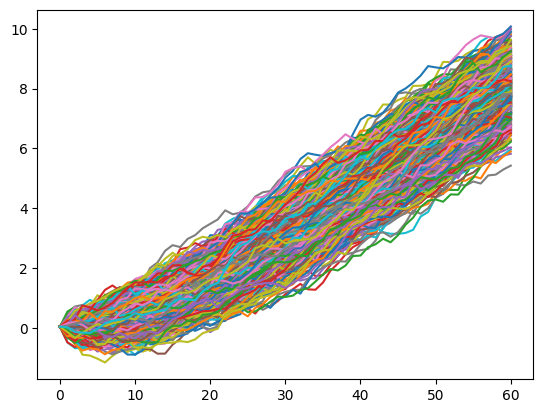

In [ ]:
plt.plot(short_rate_df_ql)
plt.show()

In [ ]:
hwmodel_ql = ql.HullWhite(hrate_curve_ql, a, sigma)

In [ ]:
for i, t in enumerate(time_grid):
    hw_bonds_tmp = tf.stack([hw_tq.zero_bond(t, time, short_rate[:,i]) for time in rate_curve._pillars])
    curve_tensor_tmp = tq.RateCurve.from_zcb(evaluation_date, times, hw_bonds_tmp , "LINEAR")

60

In [ ]:
i = 1
t = time_grid[i]

# tq
# len pillars x paths
hw_bonds_tmp = tf.stack([hw_tq.zero_bond(t, time, short_rate[:,i]) for time in rate_curve._pillars])
# hw_bonds_tmp = tf.transpose(hw_bonds_tmp)

#ql
rs_ql = short_rate[:,i].numpy().tolist()
hw_bonds_tmpql = np.zeros((len(rate_curve._pillars), Npaths))
# hw_bonds_tmpql = [hwmodel_ql.discountBond(t, time, short_rate[:,i].numpy().tolist()) for time in rate_curve._pillars]
for n in range(Npaths):
    hw_bonds_tmpql[:,n] = np.array([hwmodel_ql.discountBond(t, time, short_rate[n,i].numpy()) for time in rate_curve._pillars])

In [ ]:
rate_curve_tensor = tq.RateCurve.from_zcb(evaluation_date, times, hw_bonds_tmp , "LINEAR")
rate_curve_tensor.discount(1.5)

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([0.96522383, 1.0215521 , 0.98400154, 1.22091082, 1.08720307,
       0.89263252, 0.87826842, 1.03076466, 1.03098704, 0.82138992,
       0.73998477, 0.93268331, 1.23118188, 0.92014872, 0.89386699,
       0.92962047, 0.96036732, 0.85988001, 1.08374031, 0.9328379 ,
       1.02084031, 0.921907  , 0.84429618, 1.07798137, 0.77873634,
       1.09479631, 0.99264737, 0.85509484, 0.83169149, 0.95924048,
       0.77361013, 1.05299945, 0.94488903, 1.02073888, 1.07709502,
       0.84536344, 0.96134325, 1.02097479, 1.07030212, 0.90341185,
       1.16964033, 1.03070814, 0.76749616, 1.04567471, 0.99729157,
       0.89131707, 1.05728893, 1.06648915, 1.07179209, 0.93041744,
       0.9164206 , 0.77938626, 1.03093051, 0.92360552, 1.08289028,
       0.88432548, 1.09596248, 0.9536454 , 0.88907386, 1.01674763,
       1.01611796, 0.95285098, 1.06568299, 0.9476299 , 0.98098591,
       0.83004441, 1.01316267, 0.82882892, 1.02452008, 0.90044772,
       0.9568

In [ ]:
rate_curve_tensor2 = tq.RateCurve.from_zcb(evaluation_date, times, hw_bonds_tmp[:,3] , "LINEAR")
rate_curve_tensor2.discount(1.5)

<tf.Tensor: shape=(), dtype=float64, numpy=1.2209108239739426>

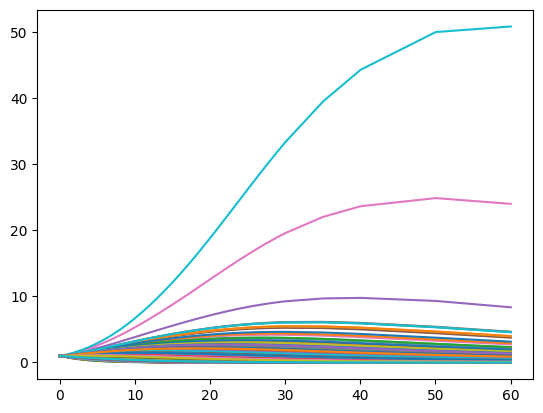

In [ ]:
# npath, curvepillar, timegrid
plt.plot(rate_curve._pillars, hw_bonds_tmp );

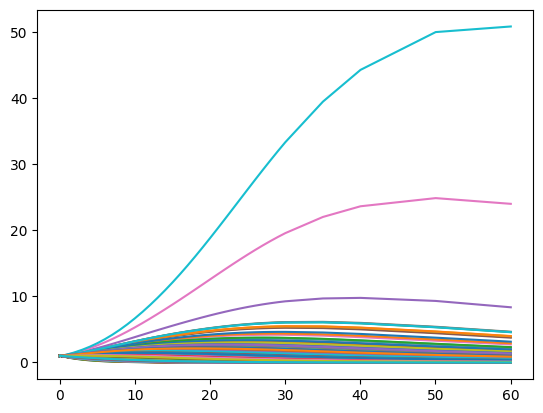

In [ ]:
# npath, curvepillar, timegrid
plt.plot(rate_curve._pillars, hw_bonds_tmpql );

In [ ]:
hw_bonds = [hw_tq.zero_bond(t, time, short_rate) for time in rate_curve._pillars]
hw_bonds = tf.stack(hw_bonds, axis=1)

time_grid_t = 2
hw_bonds_t = tf.transpose(hw_bonds[:,:,time_grid_t])

In [ ]:
time_grid_t = 2
hw_bonds_t = tf.transpose(hw_bonds[:,:,time_grid_t])

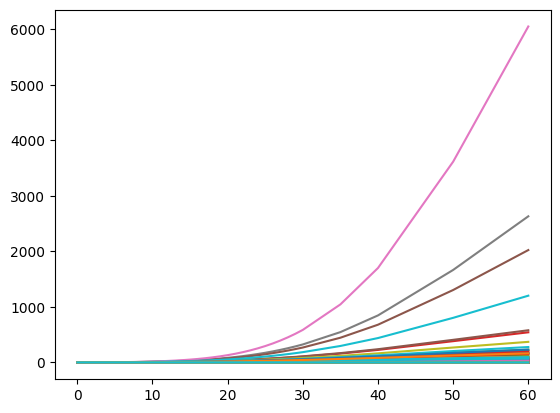

In [ ]:
# npath, curvepillar, timegrid
plt.plot(rate_curve._pillars, hw_bonds_t );

In [ ]:
rate_curve_tensor = tq.RateCurve.from_zcb(evaluation_date, times, hw_bonds[0:2,:,0] , "LINEAR")

In [ ]:
rate_curve_tensor.discount(60.)

<tf.Tensor: shape=(62,), dtype=float64, numpy=
array([2.08736926e-001, 9.53671765e-002, 9.08149007e-003, 4.13779011e-003,
       1.70254344e-005, 6.99549205e-008, 6.00221864e-011, 1.82892263e-020,
       1.00182294e-030, 1.35497783e-040, 2.93714395e-050, 2.47344790e-059,
       2.29481716e-068, 1.49740201e-077, 1.60410276e-086, 7.92779602e-095,
       1.41087458e-103, 8.40419020e-112, 1.05654233e-119, 7.90810680e-128,
       1.74997648e-135, 4.09112515e-143, 3.23223123e-151, 1.29477689e-158,
       9.88663881e-166, 1.52225571e-173, 3.65733488e-181, 6.36448313e-188,
       3.43785295e-195, 1.00943300e-202, 2.32510782e-284, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+

In [ ]:
# test curve future zcb vs ql
# pricing swap a date future

# OLD

In [ ]:
hw = tq.HullWhiteProcess(a, sigma, rate_curve)
hw_kernel = tq.GaussianRateKernel1D(hw)

# simulate short rate and discount curve 
paths = int(1e6) 
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(paths,
                                                  last_grid_time=1,
                                                  time_steps=2) 
# Reshape the tensor and create a discount curve object
reshaped_tensor = tf.reshape(zb_tensor, shape=(zb_tensor.shape[1], paths, 1))
rate_curve_tensor = tq.RateCurve.from_zcb(evaluation_date, times, reshaped_tensor, "LINEAR")

AttributeError: 'float' object has no attribute 'inst_fwd'

In [ ]:
rate_curve_tensor.discount(2.0)